# Create a transformer that creates time series features

**Author:** Sarah Stolle  
**Date:** 20-03-2019

**Goal:** Create a transformer for the scikit-lego package that can implement automatic feature generation of time-series features that are often of interest. 

**Prerequisites:** 
- A pandas data frame that contains a datetime column

### Load packages

In [7]:
import random
import datetime as dt
import numpy as np
import pandas as pd
import plotnine as pn
from sklearn.base import BaseEstimator, TransformerMixin
from sklego


### Generate example data frame

In [119]:
random.seed(121)

start_date = dt.datetime(2017, 1, 1)
end_date = dt.datetime(2019, 12,31)

def get_random_date(start_date, end_date):
    return start_date + (end_date - start_date) * random.random()

n = 5
ex_data = pd.DataFrame({
    "date": [get_random_date(start_date, end_date) for i in np.arange(n)],
    "amount": [random.randint(0,100) for i in np.arange(n)],
    "y": [random.randint(0,1) for i in np.arange(n)]
}).sort_values(by="date")
ex_data.head()

,date,amount,y
0,2017-04-06 12:11:16.220936,66,1
2,2018-03-12 03:21:47.469091,42,1
1,2018-10-01 16:27:54.369271,22,0
4,2018-11-04 05:49:04.951890,23,0
3,2019-09-28 15:20:07.702827,36,0


In [123]:
np.random.randint(0, 2, 5)

array([0, 0, 0, 1, 1])

In [64]:
isinstance(ex_data['date'], np.datetime64)

False

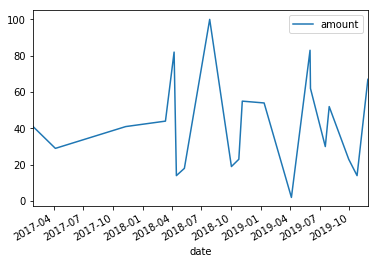

In [15]:
ex_data.plot("date", "amount")

### Generate days of the week feature

In [12]:
def get_days_of_week(dataf: pd.DataFrame, date_col: str="date"):
    """
    The day of the week with Monday=0, Sunday=6.
    
    :param dataf: data frame that contains a date column. (type pandas.DataFrame)
    :param date_col: name of the date column
    :returns pandas.DataFrame with an extra column day_of_week
    """
    
    return dataf.assign(day_of_week=lambda d: d[date_col].dt.dayofweek)
    

In [80]:
ex_data = ex_data.pipe(get_days_of_week)
ex_data.head()

,date,amount,y,day_of_week
15,2017-01-27 16:35:12.885618,41,1,4
0,2017-04-06 12:11:16.220936,29,1,3
7,2017-11-09 12:49:13.681169,41,1,3
2,2018-03-12 03:21:47.469091,44,1,0
9,2018-04-07 19:34:24.664380,82,0,5


### Create time-series-feature-adder class

In [142]:
class TimeSeriesFeatureAdder(TransformerMixin, BaseEstimator):
    """
    Add common time-series features to data frame in your scikit-learn pipeline. 
    Currently it return the day of the week. 
    
    :param date_col: name of the date column (default= 'date')
    :param make_dummies: boolean whether the days of week will be added as dummy variables or as one column (default= false)
    
    """
    
    def __init__(self, date_col="date", make_dummies=False):
        self.date_col = date_col
        self.make_dummies = make_dummies
        
    def fit(self, X, y):
        _ = X.get(self.date_col, f"Date column {self.date_col} doesn't exist. Please provide another one.")
        if isinstance(_, str):
            print (_)

#         TODO: check that column is date time, below doesn't work   
#         assert isinstance(X[date_col], np.datetime64)
        return self
    
    def transform(self, X, y):
        X = self._get_days_of_week(X, self.date_col)
        
        return X
    
    
    def _get_days_of_week(self, dataf: pd.DataFrame, date_col: str="date"):
        """
        The day of the week with Monday=0, Sunday=6.

        :param dataf: data frame that contains a date column. (type pandas.DataFrame)
        :returns pandas.DataFrame with an extra column day_of_week
        """
        df_with_days_of_week = dataf.assign(day_of_week=lambda d: d[date_col].dt.dayofweek)
        if self.make_dummies:
            df_with_days_of_week = pd.get_dummies(df_with_days_of_week, columns=["day_of_week"], prefix="day", 
                                                  dtype=int)
        
        return df_with_days_of_week


In [133]:
start_date = dt.datetime(2019, 1, 1)
end_date = dt.datetime(2019, 1, 10)

ex_data = pd.DataFrame({
    "date": pd.date_range(start_date, end_date, freq="2D"),
    "amount": [85, 61, 38, 74, 18],
    "y": [0, 1, 1, 0, 0]
}).sort_values(by="date")
ex_data

,date,amount,y
0,2019-01-01,85,0
1,2019-01-03,61,1
2,2019-01-05,38,1
3,2019-01-07,74,0
4,2019-01-09,18,0


In [143]:
y = ex_data["y"]
X = ex_data.loc[:, ex_data.columns.isin(["date", "amount"])].reset_index(drop=True)
tsfa = TimeSeriesFeatureAdder(make_dummies=True)
tsfa.fit(X,y)
result= tsfa.transform(X,y)
result

,date,amount,day_0,day_1,day_2,day_3,day_5
0,2019-01-01,85,0,1,0,0,0
1,2019-01-03,61,0,0,0,1,0
2,2019-01-05,38,0,0,0,0,1
3,2019-01-07,74,1,0,0,0,0
4,2019-01-09,18,0,0,1,0,0


In [144]:
expected_result = (X
                   .assign(
                    day_0=[0, 0, 0, 1, 0],
                    day_1=[1, 0, 0, 0, 0],
                    day_2=[0, 0, 0, 0, 1],
                    day_3=[0, 1, 0, 0, 0],
                    day_5=[0, 0, 1, 0, 0]))

In [145]:
result.dtypes

date      datetime64[ns]
amount             int64
day_0              int64
day_1              int64
day_2              int64
day_3              int64
day_5              int64
dtype: object

In [146]:
pd.testing.assert_frame_equal(result, expected_result)